# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install git+https://github.com/tensorflow/privacy

     |████████████████████████████████| 4.0 MB 5.0 MB/s 


##### Import libraries

In [4]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [5]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
100% 780M/780M [00:07<00:00, 107MB/s] 


##### Define constants

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.53
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [7]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [8]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [9]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [10]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [11]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [12]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7232, Val: 452, Test: 1356


In [13]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [14]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4339, 'COVID-19': 2893}
val set:  {'normal': 272, 'COVID-19': 180}
test set:   {'normal': 813, 'COVID-19': 543}


###### Create tensors

In [15]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [16]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [17]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [18]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [19]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [20]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [21]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [22]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [23]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [24]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=False,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [25]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

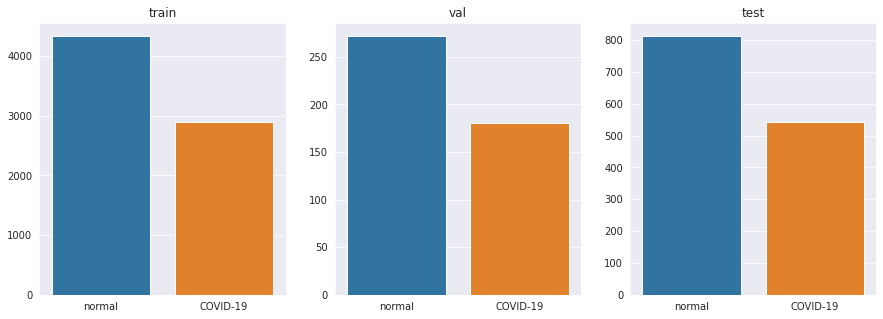

In [26]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [27]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [28]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


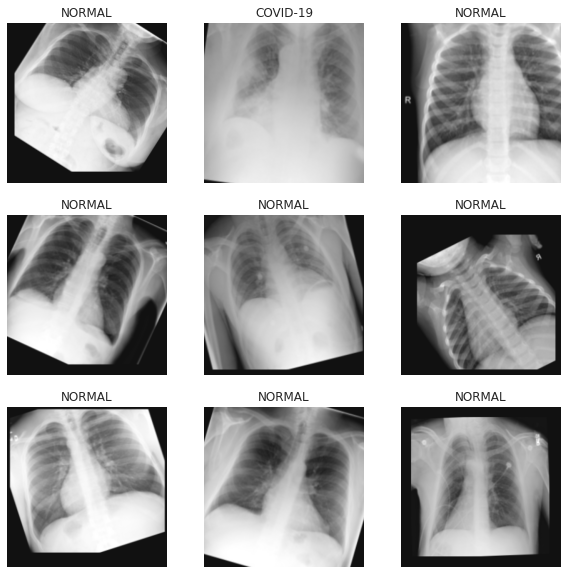

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [30]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [31]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - relu
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [32]:
def dpnet_relu_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-relu')
    return dpnet

In [33]:
dpnet_relu = dpnet_relu_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_relu.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [34]:
dpnet_relu.summary()

Model: "DP-Net-relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              

### Training

In [35]:
history_dpnet_relu = dpnet_relu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


226/226 [==============================] - 129s 467ms/step - loss: 0.7887 - accuracy: 0.5884 - precision: 0.4881 - recall: 0.5942 - val_loss: 1.1715 - val_accuracy: 0.4241 - val_precision: 0.4070 - val_recall: 0.9831
Epoch 2/20
226/226 [==============================] - 100s 445ms/step - loss: 0.8808 - accuracy: 0.6592 - precision: 0.5619 - recall: 0.6716 - val_loss: 1.0870 - val_accuracy: 0.6205 - val_precision: 0.5137 - val_recall: 0.8427
Epoch 3/20
226/226 [==============================] - 100s 443ms/step - loss: 0.8885 - accuracy: 0.6769 - precision: 0.5827 - recall: 0.6768 - val_loss: 0.9692 - val_accuracy: 0.7076 - val_precision: 0.7282 - val_recall: 0.4213
Epoch 4/20
226/226 [==============================] - 99s 440ms/step - loss: 0.8882 - accuracy: 0.6858 - precision: 0.5938 - recall: 0.6796 - val_loss: 1.1900 - val_accuracy: 0.6629 - val_precision: 0.7288 - val_recall: 0.2416
Epoch 5/20
226/226 [==============================] - 99s 439ms/step - loss: 0.8853 - accuracy: 0.69

### Evaluation

###### Visualize performance

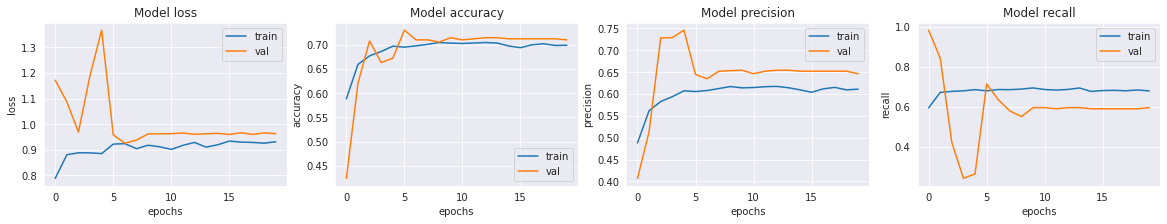

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_relu.history[met])
    ax[i].plot(history_dpnet_relu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [37]:
loss, acc, prec, rec = dpnet_relu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 78ms/step - loss: 0.9412 - accuracy: 0.7294 - precision: 0.6725 - recall: 0.6317
Loss of the model is -  0.9411634802818298
Accuracy of the model is -  72.93510437011719 %
Precision of the model is -  0.6725490093231201
Recall of the model is -  0.6316758990287781


## DP-Net - CNN Architecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [38]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net')
    return dpnet

In [39]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [40]:
dpnet.summary()

Model: "DP-Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0    

### Training

In [41]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


226/226 [==============================] - 106s 445ms/step - loss: 1.0456 - accuracy: 0.6321 - precision: 0.5345 - recall: 0.6212 - val_loss: 1.6375 - val_accuracy: 0.5112 - val_precision: 0.4444 - val_recall: 0.9213
Epoch 2/20
226/226 [==============================] - 100s 443ms/step - loss: 1.1287 - accuracy: 0.6654 - precision: 0.5726 - recall: 0.6447 - val_loss: 1.1999 - val_accuracy: 0.6741 - val_precision: 0.5678 - val_recall: 0.7528
Epoch 3/20
226/226 [==============================] - 98s 434ms/step - loss: 1.1749 - accuracy: 0.6720 - precision: 0.5817 - recall: 0.6409 - val_loss: 1.8403 - val_accuracy: 0.5848 - val_precision: 0.4879 - val_recall: 0.9045
Epoch 4/20
226/226 [==============================] - 99s 438ms/step - loss: 1.0816 - accuracy: 0.6798 - precision: 0.5911 - recall: 0.6471 - val_loss: 0.9998 - val_accuracy: 0.6942 - val_precision: 0.6952 - val_recall: 0.4101
Epoch 5/20
226/226 [==============================] - 97s 432ms/step - loss: 1.1125 - accuracy: 0.686

### Evaluation

###### Visualize performance

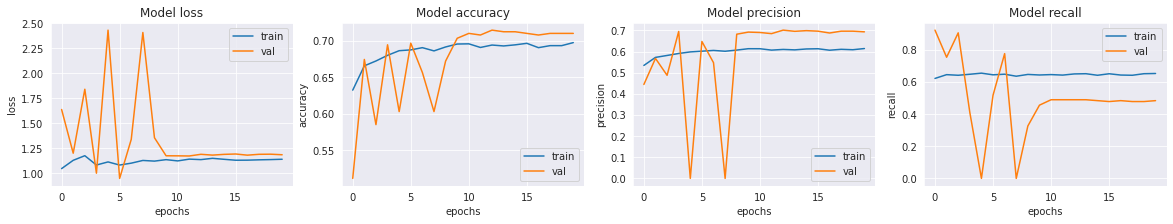

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].plot(history_dpnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [43]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 29ms/step - loss: 1.0371 - accuracy: 0.7242 - precision: 0.7118 - recall: 0.5230
Loss of the model is -  1.0370599031448364
Accuracy of the model is -  72.41888046264648 %
Precision of the model is -  0.7117794752120972
Recall of the model is -  0.5230202674865723


## DP-Net - logits
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [44]:
def dpnet_logits_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-logits')
    return dpnet

In [45]:
dpnet_logits = dpnet_logits_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_logits.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=False,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [46]:
dpnet_logits.summary()

Model: "DP-Net-logits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_6 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)            

### Training

In [47]:
history_dpnet_logits = dpnet_logits.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
226/226 [==============================] - 105s 439ms/step - loss: 1.0351 - accuracy: 0.6325 - precision: 0.5340 - recall: 0.6377 - val_loss: 1.5421 - val_accuracy: 0.5446 - val_precision: 0.4635 - val_recall: 0.9270
Epoch 2/20
226/226 [==============================] - 98s 436ms/step - loss: 1.1240 - accuracy: 0.6640 - precision: 0.5692 - recall: 0.6581 - val_loss: 1.7126 - val_accuracy: 0.6027 - val_precision: 0.5000 - val_recall: 0.8989
Epoch 3/20
226/226 [==============================] - 97s 431ms/step - loss: 1.1466 - accuracy: 0.6706 - precision: 0.5767 - recall: 0.6644 - val_loss: 0.9695 - val_accuracy: 0.6920 - val_precision: 0.7174 - val_recall: 0.3708
Epoch 4/20
226/226 [==============================] - 99s 439ms/step - loss: 1.1138 - accuracy: 0.6816 - precision: 0.5891 - recall: 0.6744 - val_loss: 1.6634 - val_accuracy: 0.6362 - val_precision: 0.5256 - val_recall: 0.8652
Epoch 5/20
226/226 [==============================] - 97s 431ms/step - loss: 1.0691 - accur

### Evaluation

###### Visualize performance

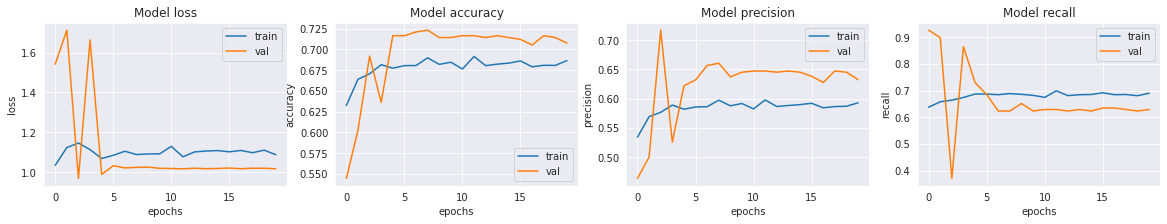

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_logits.history[met])
    ax[i].plot(history_dpnet_logits.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [49]:
loss, acc, prec, rec = dpnet_logits.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 30ms/step - loss: 0.9783 - accuracy: 0.7094 - precision: 0.6362 - recall: 0.6409
Loss of the model is -  0.9782940149307251
Accuracy of the model is -  70.94395160675049 %
Precision of the model is -  0.6361974477767944
Recall of the model is -  0.6408839821815491


## DP-Net nobn
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [50]:
def dpnet_nobn_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-nobn')
    return dpnet

In [51]:
dpnet_nobn = dpnet_nobn_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_nobn.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [52]:
dpnet_nobn.summary()

Model: "DP-Net-nobn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                230432    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 

### Training

In [53]:
history_dpnet_nobn = dpnet_nobn.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


226/226 [==============================] - 96s 406ms/step - loss: 1.5833 - accuracy: 0.5990 - precision: 0.3158 - recall: 0.0021 - val_loss: 1.3355 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
226/226 [==============================] - 90s 400ms/step - loss: 1.6344 - accuracy: 0.6000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5180 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
226/226 [==============================] - 91s 403ms/step - loss: 1.6512 - accuracy: 0.6000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1914 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
226/226 [==============================] - 91s 405ms/step - loss: 1.6346 - accuracy: 0.6000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4431 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
226/226 [===========================

### Evaluation

###### Visualize performance

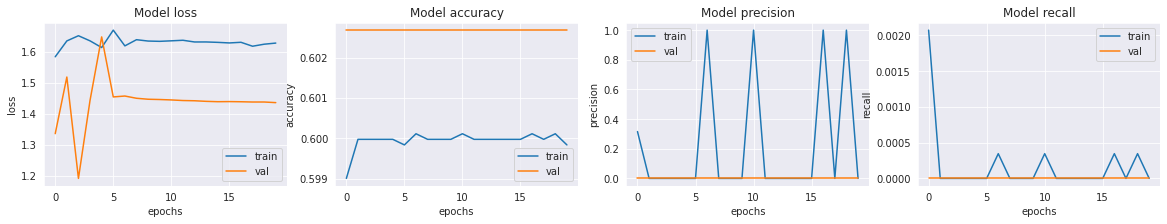

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_nobn.history[met])
    ax[i].plot(history_dpnet_nobn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [55]:
loss, acc, prec, rec = dpnet_nobn.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 29ms/step - loss: 1.4486 - accuracy: 0.5996 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss of the model is -  1.4485565423965454
Accuracy of the model is -  59.95575189590454 %
Precision of the model is -  0.0
Recall of the model is -  0.0


## DP-Net pneu
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [56]:
def dpnet_pneu_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-pneu')
    return dpnet

In [57]:
dpnet_pneu = dpnet_pneu_builder()

# load weights from pneumonia pretraining
dpnet_pneu.load_weights(weights_path+'dpnet_tanh_public_weights.h5')

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_pneu.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [58]:
dpnet_pneu.summary()

Model: "DP-Net-pneu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7200)              

### Training

In [59]:
history_dpnet_pneu = dpnet_pneu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


226/226 [==============================] - 105s 439ms/step - loss: 1.0061 - accuracy: 0.6757 - precision: 0.5701 - recall: 0.7698 - val_loss: 5.5195 - val_accuracy: 0.3973 - val_precision: 0.3973 - val_recall: 1.0000
Epoch 2/20
226/226 [==============================] - 99s 440ms/step - loss: 1.1035 - accuracy: 0.6944 - precision: 0.5906 - recall: 0.7698 - val_loss: 2.2511 - val_accuracy: 0.5938 - val_precision: 0.4942 - val_recall: 0.9494
Epoch 3/20
226/226 [==============================] - 99s 438ms/step - loss: 1.1977 - accuracy: 0.6932 - precision: 0.5902 - recall: 0.7622 - val_loss: 3.7851 - val_accuracy: 0.4040 - val_precision: 0.3995 - val_recall: 0.9944
Epoch 4/20
226/226 [==============================] - 99s 441ms/step - loss: 1.1457 - accuracy: 0.7005 - precision: 0.5983 - recall: 0.7646 - val_loss: 1.2604 - val_accuracy: 0.7143 - val_precision: 0.6524 - val_recall: 0.6011
Epoch 5/20
226/226 [==============================] - 100s 441ms/step - loss: 1.1092 - accuracy: 0.704

### Evaluation

###### Visualize performance

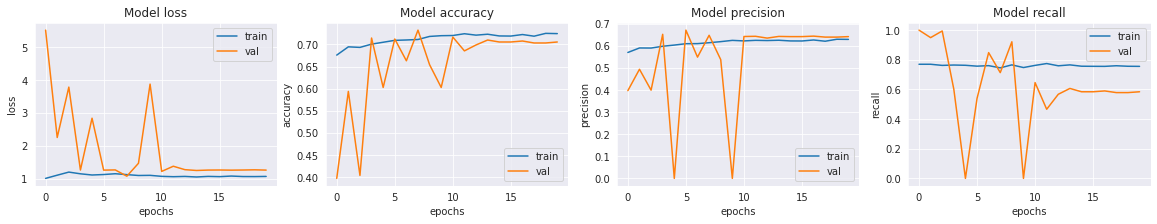

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_pneu.history[met])
    ax[i].plot(history_dpnet_pneu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [61]:
loss, acc, prec, rec = dpnet_pneu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 30ms/step - loss: 1.1766 - accuracy: 0.7109 - precision: 0.6495 - recall: 0.6041
Loss of the model is -  1.1766021251678467
Accuracy of the model is -  71.09144330024719 %
Precision of the model is -  0.6495049595832825
Recall of the model is -  0.6040515899658203


## Evaluation

In [62]:
models = [
    dpnet_relu,
    dpnet,
    dpnet_logits,
    dpnet_nobn,
    dpnet_pneu,
]

### Model Analysis

In [63]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating DP-Net-relu ...
43/43 [==============================] - 1s 30ms/step - loss: 0.9412 - accuracy: 0.7294 - precision: 0.6725 - recall: 0.6317


Evaluating DP-Net ...
43/43 [==============================] - 1s 30ms/step - loss: 1.0371 - accuracy: 0.7242 - precision: 0.7118 - recall: 0.5230


Evaluating DP-Net-logits ...
43/43 [==============================] - 1s 30ms/step - loss: 0.9783 - accuracy: 0.7094 - precision: 0.6362 - recall: 0.6409


Evaluating DP-Net-nobn ...
43/43 [==============================] - 1s 31ms/step - loss: 1.4486 - accuracy: 0.5996 - precision: 0.0000e+00 - recall: 0.0000e+00


Evaluating DP-Net-pneu ...
43/43 [==============================] - 1s 30ms/step - loss: 1.1766 - accuracy: 0.7109 - precision: 0.6495 - recall: 0.6041




### Privacy Analysis

#### Compute epsilon

In [64]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [65]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [66]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 10.041


In [67]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 0.1
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.442% and noise_multiplier = 8.836744240938424 iterated over 4520 steps satisfies differential privacy with eps = 0.1 and delta = 0.0001.
8.836744240938424


#### Membership Inference Attack

In [68]:
def compute_attack_inputs(attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = np.array([x[0] for x in bc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()])
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [69]:
import scipy.stats as st

for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    SAMPLE_NB = 100
    
    train_attack_input = compute_attack_inputs(train_attack_data)
    test_attack_input = compute_attack_inputs(test_attack_data)

    aucs = []
    advs = []
    emp_eps = []
    for i in range(SAMPLE_NB):
        with suppress_stdout():
            max_auc, max_adv = run_mia(model, train_attack_input, test_attack_input)
        aucs.append(max_auc)
        advs.append(max_adv)
        emp_eps.append(empirical_eps(max_auc))

    auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
    eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

    print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
    print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
    print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
    print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on DP-Net-relu...
95%-CI based on 100 attack samples
AUC: 0.53-0.53
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.11-0.14

Membership Inference Attack on DP-Net...
95%-CI based on 100 attack samples
AUC: 0.54-0.55
Attacker advantage: 0.13-0.14
Empirical epsilon bounds from AUC: 0.16-0.19

Membership Inference Attack on DP-Net-logits...
95%-CI based on 100 attack samples
AUC: 0.53-0.54
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.13-0.16

Membership Inference Attack on DP-Net-nobn...
95%-CI based on 100 attack samples
AUC: 0.54-0.54
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.14-0.17

Membership Inference Attack on DP-Net-pneu...
95%-CI based on 100 attack samples
AUC: 0.53-0.54
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.12-0.15

